# Compare Data
This script is used to compare some of the simulations and different agent configurations

In [1]:
from unityagents import UnityEnvironment
import numpy as np

# import general stuff
import gym
import random
import torch
import numpy as np
from collections import deque
from scipy import signal
import matplotlib.pyplot as plt
%matplotlib inline
import pickle
# widget bar to display progress
!pip install progressbar
import progressbar as pb

# import specific / own stuff
from ddpg_agent import Agent

### plot the main results plot

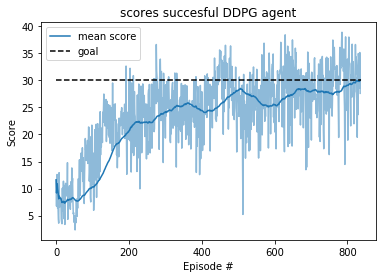

In [13]:
with open('./data/scores_DDPG_tmax2000_episodes2000_epsEnd1800_TL.pkl', 'rb') as f:
    scores = pickle.load(f)
    
def moving_average(sig, n=100):
    window = deque(maxlen=n)  # last n scores
    sig_ma = []
    for i in range(len(sig)):
        window.append(sig[i])
        sig_ma.append(np.mean(window))
    return sig_ma

scores_ma = moving_average(scores)
h = plt.plot(scores, alpha=0.5)
plt.plot(scores_ma, label='mean score', c=h[-1].get_color())
plt.plot([0, len(scores)], [30, 30], 'k--', label='goal')
plt.legend(loc='best')
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.title('scores succesful DDPG agent')
plt.savefig('./data/DDPG_results_report.png')
plt.show()

### load data for comparing multiple runs with the same parameterization

In [4]:
with open('./data/scores_DDPG_tmax2000_episodes2000_twoHiddenlayer_1.pkl', 'rb') as f:
    scores_1 = pickle.load(f)
with open('./data/scores_DDPG_tmax2000_episodes2000_twoHiddenlayer_2.pkl', 'rb') as f:
    scores_2 = pickle.load(f)
with open('./data/scores_DDPG_tmax2000_episodes2000_twoHiddenlayer_3.pkl', 'rb') as f:
    scores_3 = pickle.load(f)

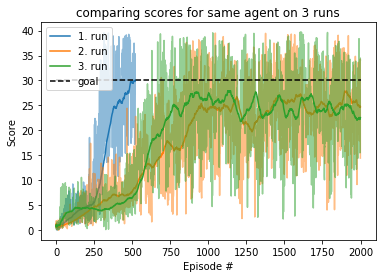

In [14]:
# butterworth filter with [order] and [cutofffreq/nyquistfreq]
b, a = signal.butter(4, 0.05/0.5)


def moving_average(sig, n=100):
    window = deque(maxlen=n)  # last n scores
    sig_ma = []
    for i in range(len(sig)):
        window.append(sig[i])
        sig_ma.append(np.mean(window))
    return sig_ma

scores_1_ma = moving_average(scores_1)
scores_2_ma = moving_average(scores_2)
scores_3_ma = moving_average(scores_3)
h = plt.plot(scores_1, alpha=0.5)
plt.plot(scores_1_ma, label='1. run', c=h[-1].get_color())
h = plt.plot(scores_2, alpha=0.5)
plt.plot(scores_2_ma, label='2. run', c=h[-1].get_color())
h = plt.plot(scores_3, alpha=0.5)
plt.plot(scores_3_ma, label='3. run', c=h[-1].get_color())
plt.plot([0, 2000], [30, 30], 'k--', label='goal')
plt.legend(loc='best')
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.title('comparing scores for same agent on 3 runs')
plt.savefig('./data/DDPG_compare_runs.png')
plt.show()

 # Simulate Ornstein-Uhlenbeck process
 This process is used for exploration. In the next short section it is simulated with different parameterization to get a better feeling what it is doing.

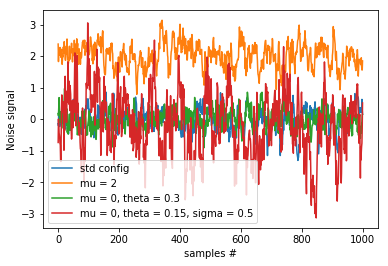

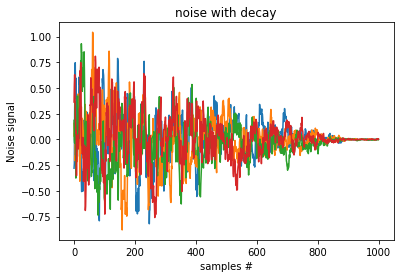

In [6]:
from ddpg_agent import OUNoise
import random
random_seed = 123

# Noise process
# mu=0., theta=0.15, sigma=0.2
# mu is the center point of the distribution
# theta draws the distribution towards the center point
# sigma draws the distribution towards random points of normal distribution
noise_std = OUNoise(1, random_seed)
noise_1 = OUNoise(1, random_seed, 2)
noise_2 = OUNoise(1, random_seed, 0., 0.3)
noise_3 = OUNoise(1, random_seed, 0., 0.15, 0.5)

# create noise
n_samples = 1000
noise_signal_std = [noise_std.sample() for i in range(n_samples)]
noise_signal_1 = [noise_1.sample() for i in range(n_samples)]
noise_signal_2 = [noise_2.sample() for i in range(n_samples)]
noise_signal_3 = [noise_3.sample() for i in range(n_samples)]

plt.plot(noise_signal_std, label='std config')
plt.plot(noise_signal_1, label='mu = 2')
plt.plot(noise_signal_2, label='mu = 0, theta = 0.3')
plt.plot(noise_signal_3, label='mu = 0, theta = 0.15, sigma = 0.5')
plt.legend(loc='best')
plt.ylabel('Noise signal')
plt.xlabel('samples #')
plt.show()

# with beta decay
noise_std = OUNoise(4, random_seed)
beta_start=1.0
beta_end=0.01
beta_nEpisodes=900
beta = beta_start                  # initialize beta, that is factor for adding noise
beta_decay_linear = (beta_start-beta_end)/beta_nEpisodes # compute linear beta decay rate
noise_signal_beta = [noise_std.sample() for i in range(n_samples)]
for i in range(n_samples):
    noise_signal_beta[i] *= beta
    beta = max(beta_end, beta_start - beta_decay_linear*i) # decrease beta
plt.plot(noise_signal_beta)
plt.ylabel('Noise signal')
plt.xlabel('samples #')
plt.title('noise with decay')
plt.show()

# PLAYGROUND - PROBABLY NOT WORTH INVESTIGATING

In [7]:
env = UnityEnvironment(file_name='.\Reacher_Windows_x86_64\Reacher.exe')
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Number of actions:', action_size)

# random actions
actions = np.random.randn(num_agents, action_size) # select an action (for each agent)
actions = np.clip(actions, -1, 1)                  # all actions between -1 and 1
print('Random set of actions: {}'.format(actions))

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		goal_speed -> 1.0
		goal_size -> 5.0
Unity brain name: ReacherBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 33
        Number of stacked Vector Observation: 1
        Vector Action space type: continuous
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


Number of agents: 1
Number of actions: 4
Random set of actions: [[ 0.47616491 -0.02747436  0.09738248  1.        ]]
There are 1 agents. Each observes a state with length: 33
The state for the first agent looks like: [ 0.00000000e+00 -4.00000000e+00  0.00000000e+00  1.00000000e+00
 -0.00000000e+00 -0.00000000e+00 -4.37113883e-08  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00 -1.00000000e+01  0.00000000e+00
  1.00000000e+00 -0.00000000e+00 -0.00000000e+00 -4.37113883e-08
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  5.75471878e+00 -1.00000000e+00
  5.55726671e+00  0.00000000e+00  1.00000000e+00  0.00000000e+00
 -1.68164849e-01]


## Check if distribution of PPO Agent works and gives expected results

In [8]:
import torch.nn as nn
from models import ActorPolicy

state_size = 33
action_size = 4
seed= 123
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

hidden_layers = [33, 33]
munetwork_local = ActorPolicy(state_size, action_size, hidden_layers, seed).to(device)

std = 0.0
log_std = nn.Parameter(torch.ones(1, action_size) * std)
print(log_std)

mu = munetwork_local(torch.from_numpy(states).float().to(device))
std   = log_std.exp().expand_as(mu).to(device)
dist  = torch.distributions.Normal(mu, std)

print(mu, std)
print(dist.sample())

Parameter containing:
tensor([[0., 0., 0., 0.]], requires_grad=True)
tensor([[-0.2714,  0.2198,  0.3821, -0.0295]],
       device='cuda:0', grad_fn=<TanhBackward>) tensor([[1., 1., 1., 1.]], device='cuda:0', grad_fn=<CopyBackwards>)
tensor([[-1.9418, -0.6393, -0.3784,  0.1150]], device='cuda:0')


In [37]:
from models import ActorPPO

print([states, states])
actor_network = ActorPPO(state_size, action_size, hidden_layers, seed).to(device)
mu, dist = actor_network(torch.from_numpy(states).float().to(device))

samples = torch.Tensor().to(device)
for i in range(1000):
    samples = torch.cat((samples, dist.sample()), dim=0)
    
#print(samples)
print('Compute mean value of 1000 samples:')
print(torch.mean(samples,dim=0))
print('Original mean value of distribution ist:')
print(mu)
print('')
print('Standard Deviation should be close to one:')
print(torch.std(samples,dim=0))

[array([[ 0.00000000e+00, -4.00000000e+00,  0.00000000e+00,
         1.00000000e+00, -0.00000000e+00, -0.00000000e+00,
        -4.37113883e-08,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00, -1.00000000e+01,
         0.00000000e+00,  1.00000000e+00, -0.00000000e+00,
        -0.00000000e+00, -4.37113883e-08,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  5.75471878e+00,
        -1.00000000e+00,  5.55726671e+00,  0.00000000e+00,
         1.00000000e+00,  0.00000000e+00, -1.68164849e-01]]), array([[ 0.00000000e+00, -4.00000000e+00,  0.00000000e+00,
         1.00000000e+00, -0.00000000e+00, -0.00000000e+00,
        -4.37113883e-08,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00, -1.00000000e+01,
         0.00000000e+00,  1.00000000e+00, -0.0000000

In [41]:
actions = torch.tensor(actions, dtype=torch.float32, device=device)
print(actions)
print(dist)
print(dist.log_prob(actions))
print(samples.size())
print(dist.sample()[0])

tensor([[ 0.4762, -0.0275,  0.0974,  1.0000]], device='cuda:0')
Normal()
tensor([[-1.1984, -0.9495, -0.9595, -1.4489]],
       device='cuda:0', grad_fn=<SubBackward>)
torch.Size([1000, 4])
tensor([ 0.7184,  0.7313, -0.5417, -1.6138], device='cuda:0')


In [34]:
def sample(states):
    idx = np.random.randint(0, states.size(0),2)
    return states[idx,:]

print(sample(samples))

score = 2
trajectory = []
trajectory.append([score, actions, states])
trajectory.append([score, actions, states])
print(trajectory)
a,b,c = trajectory[0]
print(a,b,c)


tensor([[ 0.8081,  0.4018,  1.2237, -0.7862],
        [-0.2292,  0.5411, -3.1832,  1.2771]], device='cuda:0')
[[2, tensor([[ 0.4762, -0.0275,  0.0974,  1.0000]], device='cuda:0'), array([[ 0.00000000e+00, -4.00000000e+00,  0.00000000e+00,
         1.00000000e+00, -0.00000000e+00, -0.00000000e+00,
        -4.37113883e-08,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00, -1.00000000e+01,
         0.00000000e+00,  1.00000000e+00, -0.00000000e+00,
        -0.00000000e+00, -4.37113883e-08,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  5.75471878e+00,
        -1.00000000e+00,  5.55726671e+00,  0.00000000e+00,
         1.00000000e+00,  0.00000000e+00, -1.68164849e-01]])], [2, tensor([[ 0.4762, -0.0275,  0.0974,  1.0000]], device='cuda:0'), array([[ 0.00000000e+00, -4.00000000e+00,  0.00000000e+00,
         1.00000000e+00, -0.00000000e+0

In [42]:
print(np.arange(len([1, 2, 3])))

[0 1 2]


## get one sample trajectory

In [11]:
        # get discounts ready
        discount = discount**np.arange(len(rewards))
        rewards = np.asarray(rewards)*discount[:,np.newaxis] 

        # convert everything to torch 
        actions = torch.tensor(actions, dtype=torch.float32, device=device)
        rewards = torch.tensor(rewards, dtype=torch.float32, device=device)

        # convert states to policy (or probability)
        _, dist = self.munetwork(states)         # get distribution
        log_probs = dist.log_probs(actions)      # get probability
        
        # get state values
        values = self.qnetwork(states, actions)
              
        # convert rewards to future rewards
        rewards_future = torch.empty(rewards.shape[0], rewards.shape[1], dtype=torch.float, device=device)
        for i in range(rewards.shape[0]):
            rewards_future[i,:] = torch.sum(rewards[i:,:],dim=0)

        # normalization
        mean = torch.mean(rewards_future, dim=1)
        std = torch.std(rewards_future, dim=1) + 1.0e-10
        rewards_normalized = (rewards_future - mean[:,np.newaxis])/std[:,np.newaxis]

NameError: name 'discount' is not defined

In [12]:
env.close()

# SOME TESTING

In [18]:
import random
import torch
import numpy as np

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [22]:
GAMME = 0.99

states = torch.empty(200,33, dtype=torch.float, device=device)
actions = torch.empty(200,4, dtype=torch.float, device=device)
rewards = torch.empty(200,1, dtype=torch.float, device=device)

# check sizes
print('Size states {}'.format(states.size()))
print('Size actions {}'.format(actions.size()))
print('Size rewards {}'.format(rewards.size()))

# convert rewards to future rewards
rewards_future = torch.empty(rewards.shape[0], rewards.shape[1], dtype=torch.float, device=device)
for i in range(rewards.shape[0]):
    rewards_future[i,:] = torch.sum(rewards[i:,:],dim=0)
print('Size future rewards {}'.format(rewards_future.size()))    

Size states torch.Size([200, 33])
Size actions torch.Size([200, 4])
Size rewards torch.Size([200, 1])
Size future rewards torch.Size([200, 1])
